In [49]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

In [8]:
# 데이터 셋을 받을 때 transform할 조건을 설정합니다.
mean = 0.5
sigma = 0.5
transform = transforms.Compose([transforms.ToTensor(), # 데이터를 불러 올 때 Tensor 타입으로 불러옵니다.  
                                 transforms.Normalize([mean], [sigma]) # 앞의 괄호는 평균, 뒤의 괄호는 표준편차이며 세 차원 모두 적용
                                ])
# root경로에 train 데이터를 다운 받습니다. 이 때 조건은 transform 조건에 따라 Tensor 타입과 Normalize가 된 상태로 받습니다.
training_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Dataloader를 정의합니다. Dataloader에서는 batch size와 shuffle을 세팅해줍니다.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [9]:
# Tensor 형태의 이미지 데이터를 원래 데이터로 바꿉니다.
def imgConvert(tensor):
    # tensor를 복사하고 그래프와 독립적으로 분리한 다음 numpy로 변형합니다.
    image = tensor.clone().detach().numpy()
    # Pytorch에서 제공하는 (H, W, C) 순서의 차원을 (H, W, C)로 변경합니다.
    image = image.transpose(1, 2, 0)
    # Normalize한 이미지 데이터를 원상 복귀 합니다.
    image = image * sigma + mean
    # 이미지의 범위를 0과 1 사이로 고정시킵니다.
    image = image.clip(0, 1)
    return image  

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([100, 1, 28, 28])


In [50]:
# Neural Network Class
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x     

In [51]:
model = Classifier(784, 125, 65, 10)

In [52]:
loss_func = nn.CrossEntropyLoss()

In [53]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
epochs = 12
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [55]:
for epoch in tqdm(range(epochs)):
    running_loss, val_running_loss = 0.0, 0.0
    running_corrects, val_running_corrects = 0.0, 0.0
    
    # 학습 데이터를 batch 단위로 가져와서 학습시킵니다.
    for inputs, labels in training_loader:
        # (배치사이즈, 1*28*28)로 reshape 합니다.
        inputs = inputs.view(inputs.shape[0], -1)
        # feedforward
        outputs = model(inputs)
        # loss를 계산합니다.
        loss = loss_func(outputs, labels)
        # gradient 초기화
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # weight update
        optimizer.step()
        
        # output의 각 이미지 별로 class가 가장 큰 값을 가져옵니다.
        _, preds = torch.max(outputs, 1)
        
        # loss를 더해줍니다.
        running_loss += loss.item()
        # 분류가 잘 된 갯수를 더해줍니다.
        running_corrects += torch.sum(preds == labels.data)
    
    # epoch의 loss를 계산합니다.
    epoch_loss = running_loss/len(training_loader)
    running_loss_history.append(epoch_loss)
    
    # epoch의 accuracy를 계산합니다.
    epoch_acc = running_corrects/len(training_loader)
    running_corrects_history.append(epoch_acc)
    
    # 평가 데이터를 feedforward할 때에는 gradient가 필요없습니다.
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            # training 과정과 유사하나 학습이 필요없으므로 backprob하고 weight 업데이트 하는 과정이 없습니다.
            val_inputs = val_inputs.view(val_inputs.shape[0], -1)
            val_outputs = model(val_inputs)
            val_loss = loss_func(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds==val_labels.data)
    
    # 평가 데이터의 loss와 accuracy를 저장해줍니다.
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    
    val_epoch_acc = val_running_corrects / len(validation_loader)
    val_running_corrects_history.append(val_epoch_acc)
    
    # 매 epoch의 학습과 평가가 끝났으면 결과를 출력해줍니다.
    print('training loss : {:4f}, acc : {:4f}, validation loss : {:4f}, acc : {:4f}'.format(
        epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))

  0%|                                                                        | 0/12 [00:00<?, ?it/s]

training loss : 0.537915, acc : 80.000000, validation loss : 0.439152, acc : 84.000000


  8%|█████▎                                                          | 1/12 [00:25<04:43, 25.79s/it]

training loss : 0.390549, acc : 85.000000, validation loss : 0.405058, acc : 84.000000


 17%|██████████▋                                                     | 2/12 [00:51<04:17, 25.78s/it]

training loss : 0.351841, acc : 87.000000, validation loss : 0.379083, acc : 86.000000


 25%|████████████████                                                | 3/12 [01:17<03:52, 25.83s/it]

training loss : 0.323910, acc : 88.000000, validation loss : 0.372411, acc : 86.000000


 33%|█████████████████████▎                                          | 4/12 [01:45<03:32, 26.52s/it]

training loss : 0.306255, acc : 88.000000, validation loss : 0.359574, acc : 87.000000


 42%|██████████████████████████▋                                     | 5/12 [02:13<03:08, 26.90s/it]

training loss : 0.290453, acc : 89.000000, validation loss : 0.347583, acc : 87.000000


 50%|████████████████████████████████                                | 6/12 [02:41<02:42, 27.16s/it]

training loss : 0.278987, acc : 89.000000, validation loss : 0.364252, acc : 87.000000


 58%|█████████████████████████████████████▎                          | 7/12 [03:08<02:16, 27.36s/it]

training loss : 0.265546, acc : 90.000000, validation loss : 0.361527, acc : 87.000000


 67%|██████████████████████████████████████████▋                     | 8/12 [03:37<01:50, 27.60s/it]

training loss : 0.253707, acc : 90.000000, validation loss : 0.351152, acc : 87.000000


 75%|████████████████████████████████████████████████                | 9/12 [04:05<01:23, 27.69s/it]

training loss : 0.246586, acc : 90.000000, validation loss : 0.345108, acc : 88.000000


 83%|████████████████████████████████████████████████████▌          | 10/12 [04:35<00:57, 28.58s/it]

training loss : 0.233232, acc : 91.000000, validation loss : 0.348979, acc : 87.000000


 92%|█████████████████████████████████████████████████████████▊     | 11/12 [05:05<00:29, 29.09s/it]

training loss : 0.227960, acc : 91.000000, validation loss : 0.338204, acc : 88.000000


100%|███████████████████████████████████████████████████████████████| 12/12 [05:34<00:00, 28.80s/it]


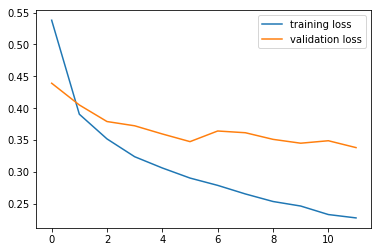

In [56]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

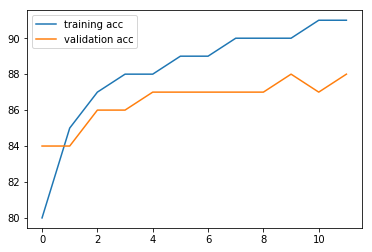

In [57]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

In [63]:
# 마지막으로 학습을 완료한 모델을 저장합니다.
torch.save(model, 'mlp.pt')

C:\Users\gauss\Anaconda3\envs\mldl\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [65]:
# 저장한 모델은 다음과 같이 load 할 수 있습니다.
model = torch.load('mlp.pt')
model.eval()

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)